# Import Libraries

In [43]:
#!pip install --upgrade scipy
#!pip install plotly
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f
from scipy.special import betainc
from scipy.stats import norm, f
from scipy.ndimage import rotate
import re
#from pandas.plotting import parallel_coordinates

# Jack's Code

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def calculate_second_gen_p_value(observed_effect=0.25, effect_interval=0.25, null_hypothesis=0, confidence_level=0.95, sample_size=60):

    '''
    % Calculate second-generation p-value for neuroimaging data
    %
    % Assuming a repeated-measures type test
    %
    % Inputs:
    %   observed_effect - estimated effect size from neuroimaging analysis
    %   null_hypothesis - point null hypothesis value
    %   effect_interval - interval of practically equivalent effects
        confidence_level - set at 0.95
        sample_size - set at 60
    %
    % Outputs:
    %   delta_p - second-generation p-value
    %   interpretation - descriptive interpretation of the result
    '''

    # Calculate z_mean and standard error
    N = sample_size
    z_mean = np.sqrt(N) * observed_effect
    z_std_error = norm.ppf(confidence_level, loc=0, scale=1) / np.sqrt(N)

    # Confidence interval
    ci_lower = z_mean - (1.96 * z_std_error)
    ci_upper = z_mean + (1.96 * z_std_error)

    # Effect interval
    interval_lower = null_hypothesis - np.sqrt(N) * effect_interval
    interval_upper = null_hypothesis + np.sqrt(N) * effect_interval

    # Calculate second-generation p-value
    if ci_upper <= interval_lower or ci_lower >= interval_upper:
        delta_p = 1
        interpretation = 'Strong evidence against null hypothesis'
    elif ci_lower <= interval_lower and ci_upper >= interval_upper:
        delta_p = 0
        interpretation = 'No conclusive evidence, data consistent with null'
    else:
        overlap_lower = max(ci_lower, interval_lower)
        overlap_upper = min(ci_upper, interval_upper)
        delta_p = (overlap_upper - overlap_lower) / (ci_upper - ci_lower)
        interpretation = 'Partial evidence, some consistency with null'

    # Visualization
    z = np.arange(-4, 4.05, 0.05) # both distributions graphed from -4 to 4 -- why?

    # Plot null distribution
    null_mu = 0
    null_sigma = 1
    null_pdf = (1 / np.sqrt(2)) * np.exp(-0.5 * ((z - null_mu) / null_sigma) ** 2)

    plt.figure(figsize=(12, 6))
    plt.plot(z, null_pdf, color='black', linewidth=2, label='Null Distribution')
    plt.axvline(x=0, color='black', linewidth=2)

    # Plot hypothetical distribution
    hypo_pdf = (1 / np.sqrt(2)) * np.exp(-0.5 * ((z - z_mean) / z_std_error) ** 2)
    plt.plot(z, hypo_pdf, color='red', linewidth=2, label='Hypothetical Distribution')
    plt.axvline(x=z_mean, color='red', linewidth=2)

    # Alpha line
    #z_alpha = norm.ppf(confidence_level, loc=0, scale=1)
    #plt.axvline(x=z_alpha, color='green', linewidth=1, label='Z critical')

    # Highlight alpha tail
    #x_fill = np.arange(z_alpha, 5, 0.01)
    #y_fill = (1 / np.sqrt(2)) * np.exp(-x_fill ** 2)
    #plt.fill_between(x_fill, 0, y_fill, color='yellow', alpha=0.5)

    # Effect and confidence intervals
    plt.plot([interval_lower, interval_upper], [0, 0], color=[0.2, 0.2, 0.2], linewidth=5, alpha=0.5, label='Effect Interval')
    plt.plot([ci_lower, ci_upper], [0, 0], color='red', linewidth=5, alpha=0.5, label='Confidence Interval')

    # Text annotations
    plt.text(-3.8, 0.9, f'Observed Effect Size = {observed_effect}')
    plt.text(-3.8, 0.85, f'Sample Size = {N}')
    plt.text(-3.8, 0.8, f'Student\'s t-value = {z_mean:.4f}', color='red')
    plt.text(-3.8, 0.75, f'Confidence Level = {confidence_level}')
    plt.text(-3.8, 0.7, f'Effect Interval = {effect_interval}')
    #plt.text(-3.8, 0.65, f'Z critical = {z_alpha:.4f}', color='green')
    plt.text(-3.8, 0.65, f'Second-Generation P-Value = {delta_p:.1f}')
    plt.text(-3.8, 0.6, f'Interpretation: {interpretation}')

    # Final touches
    plt.title('Second-Generation P-Value Visualization', fontsize=16)
    plt.xlabel('Student\'s t')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return delta_p, interpretation


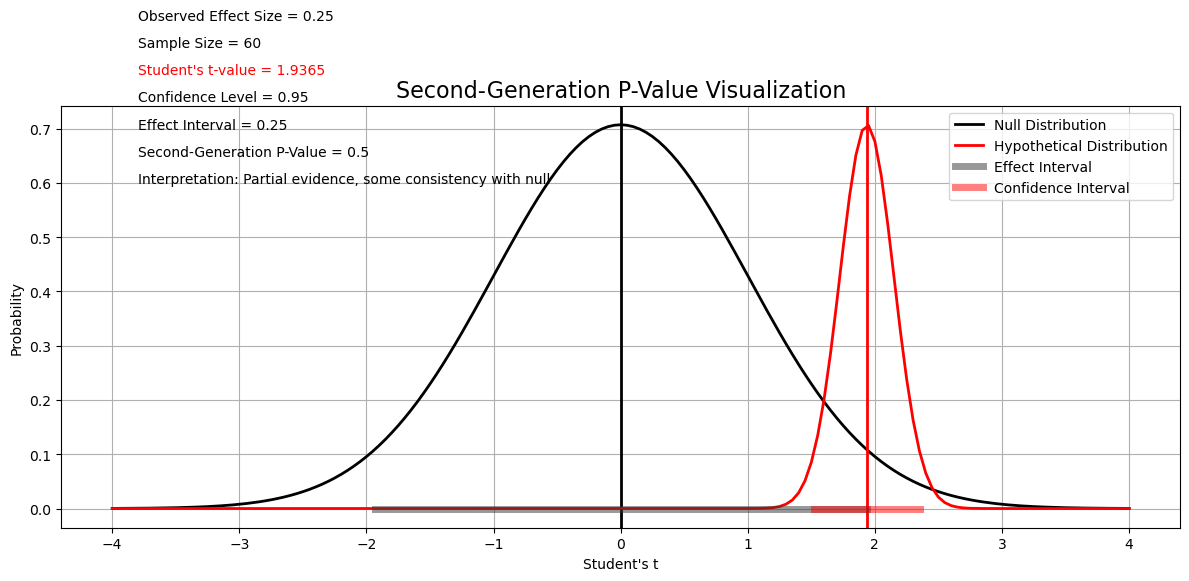

(0.5, 'Partial evidence, some consistency with null')

In [45]:
calculate_second_gen_p_value(
    observed_effect=0.25, 
    effect_interval=0.25, 
    null_hypothesis=0, 
    confidence_level=0.95, 
    sample_size=60
    )       

# Define Parameters

In [46]:
# Define parameters


# Define Functions

In [47]:
# Function to load NIfTI images
def load_nii(filename):
    return nib.load(filename)

In [48]:
# 3D Plot
def plot_3d_scatter(df):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df["Power"], df["PVal"], df["SecGenPVal"], c='blue', marker='o')
    
    ax.set_xlabel("Power")
    ax.set_ylabel("PVal")
    ax.set_zlabel("SecGenPVal")
    ax.set_title("3D Scatter Plot")

    #ax.view_init(elev=20, azim=30)
    plt.show()


# Parallel Plot
def plot_parallel_coordinates(df):
    df_norm = (df - df.min()) / (df.max() - df.min())  # Normalize values
    df_norm["Category"] = "Data"  # Needed for the color grouping
    parallel_coordinates(df_norm, class_column="Category", colormap="coolwarm")
    plt.title("Parallel Coordinates Plot")
    plt.show()

In [49]:
# Function to compute z-score from alpha
def z_score_from_alpha(alpha, tail='two-sided'):
    """
    Calculates the z-score from a given alpha value.

    Parameters:
    alpha (float): Significance level (e.g., 0.05).
    tail (str): Type of test tail ('two-sided', 'left', or 'right').
                  Defaults to 'two-sided'.

    Returns:
    float: Z-score corresponding to the alpha value.
    """
    if tail == 'two-sided':
        z = norm.ppf(1 - alpha/2)
    elif tail == 'left':
        z = norm.ppf(alpha)
    elif tail == 'right':
         z = norm.ppf(1 - alpha)
    else:
        raise ValueError("tail must be 'two-sided', 'left', or 'right'")
    return z

In [50]:
# Function for power and statistic p-value calculations
def power_calcs2(df1, df2, f2, alpha, Contrast_img):

    Fcrit = f.ppf(1 - alpha, df1, df2) # returns the inverse cumulative distribution function of the F distribution with degrees of freedom df1 and df2, evaluated at the probability value of 1 - alpha

    SPM_ZtoP = 2 * (1 - norm.cdf(Contrast_img)) #where SPM_Zobs was hardcoded 1.75 - do we need the absolute value of the zscore?

    lambda_ = (df1 + df2 + 1) * f2
    kappa = (df1 + lambda_) / df1
    df2_lambda = ((df1 + lambda_) ** 2) / (df1 + 2 * lambda_)

    F_prime = Fcrit / kappa
    x = (df2_lambda * F_prime) / (df2 + df2_lambda * F_prime)
    beta = betainc(df2_lambda / 2, df2 / 2, x)

    power = 1 - beta

    return power, SPM_ZtoP

In [52]:
# Function for second generation p-value calculations
def calculate_second_gen_p_value(observed_effect, null_hypothesis, effect_interval, f2, n, alpha, df, verbose=True):
    """
    Calculate second-generation p-value for neuroimaging data

    Parameters:
        observed_effect (float): Estimated effect size from neuroimaging analysis - Contrast_img (z scores)
        null_hypothesis (float): Point null hypothesis value (0)
        effect_interval (float): Interval of practically equivalent effects (User provides this - we need to test this value)
        f2 (float): Cohen's f-squared effect size
        n (int): Sample size
        alpha (float): Significance level
        df (int): Degrees of freedom
        verbose (bool): If True, print intermediate calculations. If False, suppress output.

    Returns:
        tuple: (delta_p, interpretation)
    """
    def vprint(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)

    vprint(f'N: {n}')
    vprint(f'alpha: {alpha}')
    vprint(f'df: {df}')

    vprint(f'Cohens f2: {f2}')
    d = 2 * f2 #in the case of 2 means (a t-test) according to Cohen's power book
    vprint(f'Cohens d: {d}\n')

    vprint(f'Z-score: {observed_effect}')
    t_val = observed_effect / (d * np.sqrt(n))
    vprint(f'T-score: {t_val}')
    
    if df == 2:
        std = z_score_from_alpha(alpha, tail='two-sided')
    elif df == 1:
        std = z_score_from_alpha(alpha, tail='right')
    else:
        vprint('error - no df specified')
        std = 1  # fallback to prevent crash
    
    vprint(f'SD: {std}')
    std_error = std / np.sqrt(n - df)
    vprint(f'SE: {std_error}')

    ci_lower = t_val - std_error
    ci_upper = t_val + std_error
    vprint(f'Confidence Interval: [{ci_lower},{ci_upper}]\n')
    
    vprint(f'Null Hypothesis: {null_hypothesis}')
    vprint(f'Effect Interval Test Value: {effect_interval}')
    interval_lower = null_hypothesis - effect_interval
    interval_upper = null_hypothesis + effect_interval
    vprint(f'Null Interval: [{interval_lower},{interval_upper}]\n')
    
    if ci_upper <= interval_upper and ci_lower >= interval_lower:
        delta_p = 1.0
        interpretation = 'The data supports the null hypothesis - not scientifically or clinically meaningful'
    elif ci_upper < interval_lower or ci_lower > interval_upper:
        delta_p = 0.0
        interpretation = 'The data supports an alternative hypothesis that is scientifically OR clinically meaningful'
    elif (ci_upper - ci_lower) > (2 * (interval_upper - interval_lower)):
        delta_p = 0.5
        interpretation = 'Data is strictly inconclusive'
    else:
        overlap_lower = max(ci_lower, interval_lower)
        overlap_upper = min(ci_upper, interval_upper)
        delta_p = (overlap_upper - overlap_lower) / (ci_upper - ci_lower)
        interpretation = 'Partial evidence, some consistency with null'

    vprint(f'Second Gen p-value: {delta_p}') 
    vprint(f'Interpretation: {interpretation}')  

    return delta_p


In [ ]:
calculate_second_gen_p_value(
    observed_effect = 6, #(>7 -> 0, <5 -> 1) for n=60, f2 = 0.2, effect_interval = 2
    null_hypothesis = 0, 
    effect_interval = 2, #should be 2? for 95% CI https://www.simplypsychology.org/z-score.html#:~:text=Around%2095%25%20of%20the%20data,between%20%2D3%20and%203)
    f2 = 0.2, 
    n = 60, 
    alpha = 0.05,
    df = 2,
    verbose = True
    )

N: 60
alpha: 0.05
df: 2
Cohens f2: 0.2
Cohens d: 0.4

Z-score: 6
T-score: 1.9364916731037083
SD: 1.959963984540054
SE: 0.2573558793434829
Confidence Interval: [1.6791357937602254,2.193847552447191]

Null Hypothesis: 0
Effect Interval Test Value: 2
Null Interval: [-2,2]

Second Gen p-value: 0.6233861978562567
Interpretation: Partial evidence, some consistency with null


0.6233861978562567

# Power, P-Val, and 2nd Gen P-Val

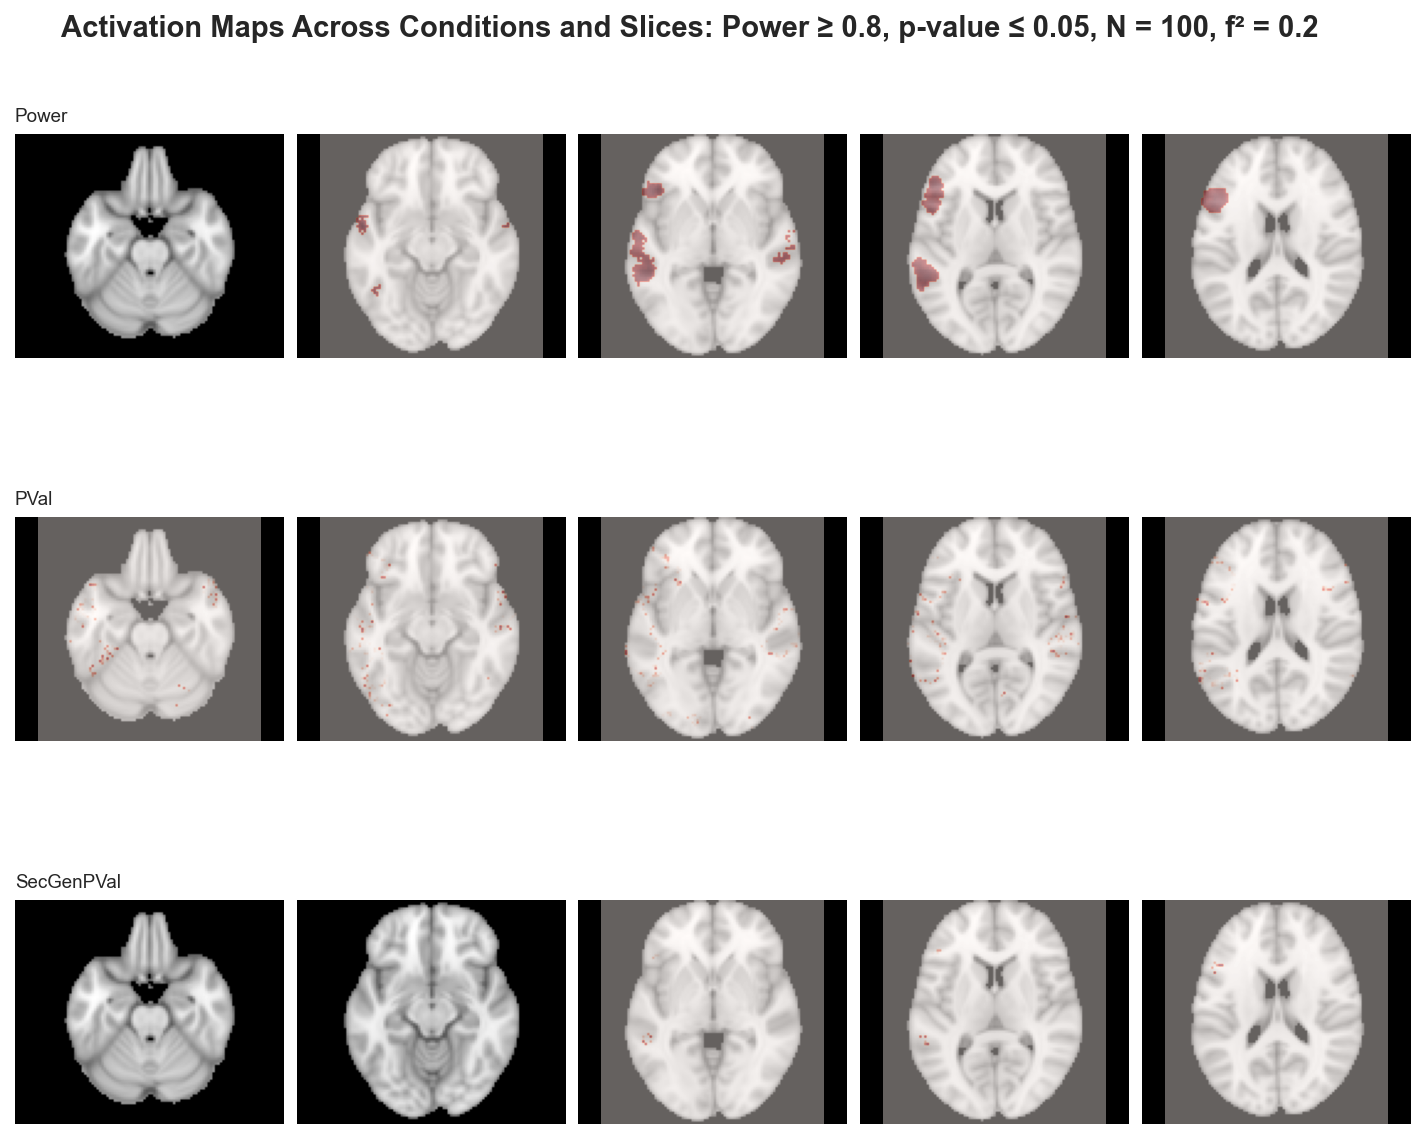

               Power           PVal     SecGenPVal
count  902629.000000  902629.000000  902629.000000
mean        0.002830       0.000001       0.000033
std         0.049890       0.000020       0.003416
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%         0.000000       0.000000       0.000000
75%         0.000000       0.000000       0.000000
max         0.991741       0.000673       0.498807


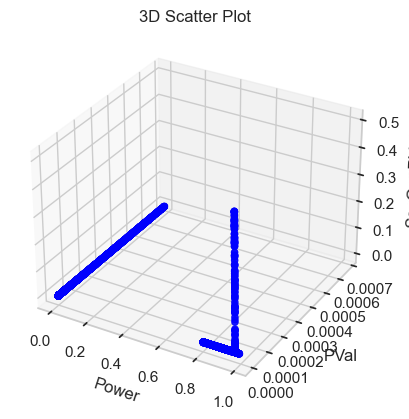

In [ ]:
# Define parameters
alphas = [0.05]
f2s = [0.2]
df = 2 #association tests - 2 way ANOVA
Ns = [100]
effect_interval = 3


# Load fMRI images
MNIAtlas = load_nii('anatomical.nii.gz')
#Contrast = load_nii('language_uniformity-test_z_FDR_0.01.nii.gz')
Contrast = load_nii('language_association_test_z_FDR_0.01.nii.gz')

# Extract image data
Contrast_img = Contrast.get_fdata()

# Compute max contrast
MaxContrast = np.max(Contrast_img)

for f2 in f2s:
    # Scale contrast images
    Contrast_Scaled = (f2 / MaxContrast) * Contrast_img

    # Get image dimensions correctly
    XDIM, YDIM, ZDIM = Contrast_img.shape
    PowerImage = np.zeros((XDIM, YDIM, ZDIM))
    PvalImage = np.zeros((XDIM, YDIM, ZDIM))
    SecGenPvalImage = np.zeros((XDIM, YDIM, ZDIM))

    for n in Ns:
        for alpha in alphas:
            for i in range(XDIM):
                for j in range(YDIM):
                    for k in range(ZDIM):
                        if Contrast_Scaled[i, j, k] != 0: ##### To Only calculate power on non-0 values -Shouldn't this  be != 0 - not >0? There are negative z scores
                            stat_power, _ = power_calcs2(
                                                df1 = df, 
                                                df2 = n, 
                                                f2 = Contrast_Scaled[i, j, k], 
                                                alpha = alpha, 
                                                Contrast_img = Contrast_img[i, j, k]
                                                )
                                                        # Power analysis
                            PowerThreshold = 1 - f2
                            if stat_power >= PowerThreshold:
                                PowerImage[i, j, k] = stat_power #adjusts 3d matrix on values to only include power values that meet threshold (overwrites default zeros)
                        if Contrast_img[i, j, k] != 0:
                            _ , stat_pval = power_calcs2(
                                                df1 = df, 
                                                df2 = n, 
                                                f2 = Contrast_img[i, j, k], 
                                                alpha = alpha, 
                                                Contrast_img = Contrast_img[i, j, k]
                                                )
                            secgenpval = calculate_second_gen_p_value(
                                                observed_effect = Contrast_img[i, j, k], 
                                                null_hypothesis = 0, 
                                                effect_interval = effect_interval, 
                                                f2 = f2, 
                                                n = n, 
                                                alpha = alpha, 
                                                df = df, 
                                                verbose=False
                                                )
                            # Pval analysis
                            if stat_pval <= alpha:
                                PvalImage[i, j, k] = stat_pval 
                            # Second Gen Pval analysis
                            if secgenpval <= 0.5:
                                SecGenPvalImage[i, j, k] = secgenpval 

            # Create empty dataframe
            table = pd.DataFrame()

            # Format filename correctly
            pvalue = str(alpha).replace('0.', '')
            f2value = str(f2).replace('0.', '0')

            # Save power image as a NIfTI file
            power_filename = f'images/PowerContrast_N{n}_p{pvalue}_Power{int(PowerThreshold * 100)}_f2{f2value}.nii.gz'
            PowerImage_nii = nib.Nifti1Image(PowerImage, Contrast.affine, Contrast.header)
            nib.save(PowerImage_nii, power_filename)

            # Save pval image as a NIfTI file
            pval_filename = f'images/PValContrast_N{n}_p{pvalue}_Power{int(PowerThreshold * 100)}_f2{f2value}.nii.gz'
            PvalImage_nii = nib.Nifti1Image(PvalImage, Contrast.affine, Contrast.header)
            nib.save(PvalImage_nii, pval_filename)

            # Save second gen pval image as a NIfTI file
            secgenpval_filename = f'images/SecGenPValContrast_N{n}_p{pvalue}_Power{int(PowerThreshold * 100)}_f2{f2value}.nii.gz'
            SecGenPvalImage_nii = nib.Nifti1Image(SecGenPvalImage, Contrast.affine, Contrast.header)
            nib.save(SecGenPvalImage_nii, secgenpval_filename)


            #### CONTRAST PLOTS ####
            # Define the activation files
            activation_files = [power_filename, pval_filename, secgenpval_filename]

            # Load the anatomical image
            img = nib.load('anatomical.nii.gz')
            data = img.get_fdata()

            # Define slices to extract
            slices_indices = [24, 30, 35, 40, 45]

            # Set up the figure
            fig, axes = plt.subplots(len(activation_files), len(slices_indices), figsize=(12, 9), dpi=150)

            # Loop through activation files
            for row, activation_file in enumerate(activation_files):
                # Load activation data
                activation = nib.load(activation_file)
                activation_data = activation.get_fdata()

                # Extract metadata from filename
                match = re.search(r'images\/(\w+)Contrast_N(\d+)_p(\d+)_Power(\d+)_f2(\d+).nii.gz', activation_file)
                if match:
                    stat_choice = match.group(1)
                    f_value = float(match.group(5)) / 10
                    n_value = match.group(2)
                    p_value = float(match.group(3)) / 100
                    power_value = float(match.group(4)) / 100
                    title_text = f"{stat_choice}"
                else:
                    title_text = "Activation Map"

                # Append data to empty dataframe
                lst = list(activation_data.flatten())
                table[stat_choice] = lst

                # Loop through slices
                for col, slice_idx in enumerate(slices_indices):
                    slice_img = data[:, :, slice_idx]
                    activation_img = activation_data[:, :, slice_idx]

                    # Rotate images
                    rotated_slice = np.flip(rotate(slice_img, 90, reshape=False, mode='constant', cval=0), axis=1)
                    rotated_activation = np.flip(rotate(activation_img, 90, reshape=False, mode='constant', cval=0), axis=1)

                    ax = axes[row, col] if len(activation_files) > 1 else axes[col]
                    ax.imshow(rotated_slice, cmap='gray')
                    ax.imshow(np.ma.masked_where(rotated_activation == 0, rotated_activation), cmap='Reds', alpha=0.4)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    ax.set_frame_on(False)

                    # Add title to first column in each row
                    if col == 0:
                        ax.set_title(title_text, fontsize=9, loc='left')

            # Optional global figure title
            fig.suptitle(f"Activation Maps Across Conditions and Slices: Power ≥ {power_value}, p-value ≤ {p_value}, N = {n_value}, f² = {f_value}", fontsize=14, fontweight='bold', y=0.95)
            plt.subplots_adjust(wspace=0.05, hspace=0.4)
            plt.show()


            ### VISUALIZE Table (only contains thresholded values - everything else 0s###
            print(table.describe())
            
            # 3D Plot
            plot_3d_scatter(table)

            # Parallel Plot
            #plot_parallel_coordinates(table)

               Power           PVal     SecGenPVal
count  901916.000000  902629.000000  902629.000000
mean        0.010424       0.001581       0.014371
std         0.083453       0.056181       0.117658
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%         0.000000       0.000000       0.000000
75%         0.000000       0.000000       0.000000
max         0.991741       1.999999       1.000000


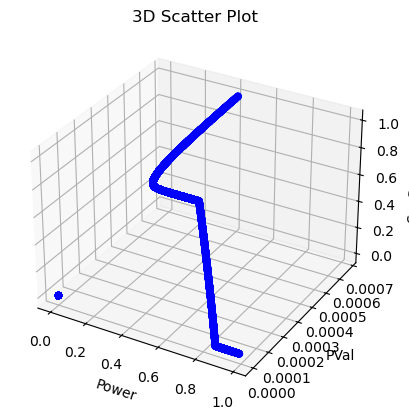

In [99]:
# Define parameters
alphas = [0.05]
f2s = [0.2]
df = 2 #association tests - 2 way ANOVA
Ns = [100]
effect_interval = 2


# Load fMRI images
MNIAtlas = load_nii('anatomical.nii.gz')
#Contrast = load_nii('language_uniformity-test_z_FDR_0.01.nii.gz')
Contrast = load_nii('language_association_test_z_FDR_0.01.nii.gz')

# Extract image data
Contrast_img = Contrast.get_fdata()

# Compute max contrast
MaxContrast = np.max(Contrast_img)

for f2 in f2s:
    # Scale contrast images
    Contrast_Scaled = (f2 / MaxContrast) * Contrast_img

    # Get image dimensions correctly
    XDIM, YDIM, ZDIM = Contrast_img.shape
    PowerImage = np.zeros((XDIM, YDIM, ZDIM))
    PvalImage = np.zeros((XDIM, YDIM, ZDIM))
    SecGenPvalImage = np.zeros((XDIM, YDIM, ZDIM))

    for n in Ns:
        for alpha in alphas:
            for i in range(XDIM):
                for j in range(YDIM):
                    for k in range(ZDIM):
                        if Contrast_Scaled[i, j, k] != 0: ##### To Only calculate power on non-0 values -Shouldn't this  be != 0 - not >0? There are negative z scores
                            stat_power, _ = power_calcs2(
                                                df1 = df, 
                                                df2 = n, 
                                                f2 = Contrast_Scaled[i, j, k], 
                                                alpha = alpha, 
                                                Contrast_img = Contrast_img[i, j, k]
                                                )
                                                        # Power analysis
                            PowerImage[i, j, k] = stat_power #adjusts 3d matrix on values to only include power values that meet threshold (overwrites default zeros)
                        if Contrast_img[i, j, k] != 0:
                            _ , stat_pval = power_calcs2(
                                                df1 = df, 
                                                df2 = n, 
                                                f2 = Contrast_img[i, j, k], 
                                                alpha = alpha, 
                                                Contrast_img = Contrast_img[i, j, k]
                                                )
                            secgenpval = calculate_second_gen_p_value(
                                                observed_effect = Contrast_img[i, j, k], 
                                                null_hypothesis = 0, 
                                                effect_interval = effect_interval, 
                                                f2 = f2, 
                                                n = n, 
                                                alpha = alpha, 
                                                df = df, 
                                                verbose=False
                                                )
                            # Pval analysis
                            PvalImage[i, j, k] = stat_pval 
                            # Second Gen Pval analysis
                            SecGenPvalImage[i, j, k] = secgenpval 

            # Create empty dataframe
            table = pd.DataFrame()

            table['Power'] = PowerImage.flatten()
            table['PVal'] = PvalImage.flatten()
            table['SecGenPVal'] = SecGenPvalImage.flatten()

            ### VISUALIZE Table (only contains thresholded values - everything else 0s###
            print(table.describe())
            
            # 3D Plot
            plot_3d_scatter(table)

            # Parallel Plot
            #plot_parallel_coordinates(table)

In [ ]:
# Step 1: Replace NaN values in the 'Power' column with 0
table['Power'] = table['Power'].fillna(0)

# Step 2: Remove rows where all columns ('Power', 'PVal', 'SecGenPVal') are zero
table = table[~((table['Power'] == 0) & (table['PVal'] == 0) & (table['SecGenPVal'] == 0))]

# Step 3: Remove rows where PVal >= 1.999
table = table[table['PVal'] < 1.999]


In [111]:
import plotly.express as px

# 1. 3D Scatter Plot
fig = px.scatter_3d(table.sample(5000), x='Power', y='PVal', z='SecGenPVal',
                    opacity=0.5, color='SecGenPVal', title='3D Scatter: Power vs PVal vs SecGenPVal')
fig.show()

In [112]:
# 2. Interactive scatter plots with sliders or hover
fig = px.scatter(table.sample(10000), x='PVal', y='SecGenPVal', color='Power',
                 opacity=0.4, title='SecGenPVal vs PVal colored by Power')
fig.show()


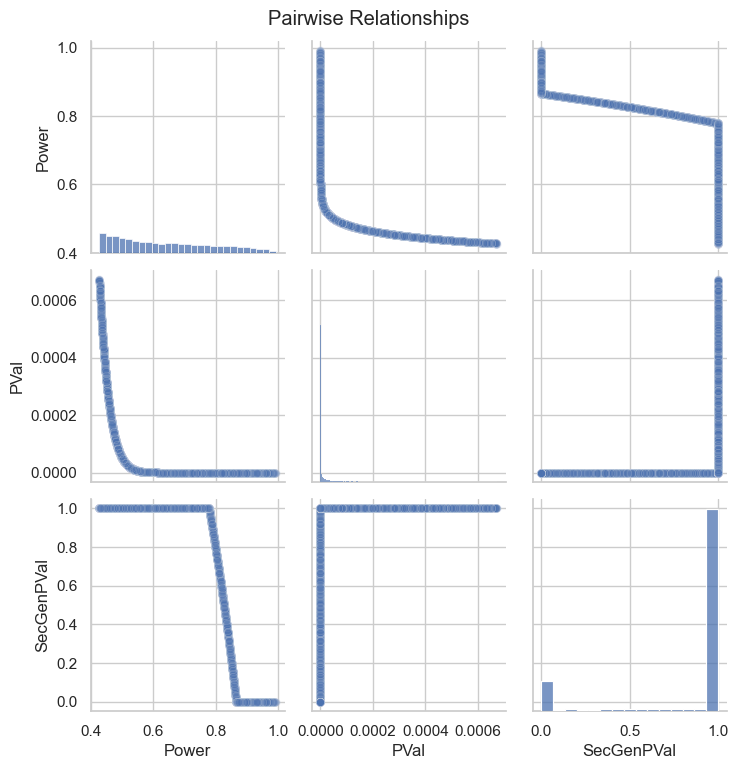

In [113]:
import seaborn as sns

# Assuming `table` is your DataFrame
sns.set(style="whitegrid", context="notebook")

# 1. Pairplot: See all relationships at once
sns.pairplot(table[['Power', 'PVal', 'SecGenPVal']], plot_kws={'alpha': 0.1})
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()


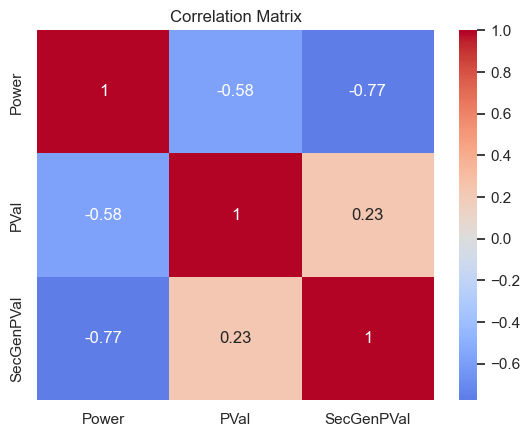

In [114]:
# Heatmap of correlations
corr = table[['Power', 'PVal', 'SecGenPVal']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()